In [1]:
!git clone https://github.com/Whauv/MultispeCOD.git

Cloning into 'MultispeCOD'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# Import libraries
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

class CorrectedMUDCADXLoader:
    """Corrected data loader for MUDCAD-X with proper folder structure"""

    def __init__(self, dataset_root_path, image_size=(512, 512)):
        self.dataset_root = dataset_root_path
        self.image_size = image_size

        # Define the exact spectral band files as shown in your structure
        self.band_files = [
            'vis.png',    # Visible spectrum
            'blue.png',   # Blue band
            'green.png',  # Green band
            'red.png',    # Red band
            'eir.png',    # Edge Infrared
            'nir.png',    # Near Infrared
            'lwir.png'    # Long Wave Infrared
        ]
        self.label_file = 'label.png'

    def discover_captures(self):
        """Discover all capture folders with their numbered subfolders"""
        captures = []
        dataset_path = os.path.join(self.dataset_root, 'MUDCAD-X-main', 'dataset')

        print(f"Searching in: {dataset_path}")

        if not os.path.exists(dataset_path):
            print(f"❌ Dataset path not found: {dataset_path}")
            return captures

        # Navigate through: season -> date -> rk -> a -> capture -> height -> numbered_folders
        for season in os.listdir(dataset_path):
            season_path = os.path.join(dataset_path, season)
            if not os.path.isdir(season_path):
                continue

            print(f"📁 Processing season: {season}")

            for date in os.listdir(season_path):
                date_path = os.path.join(season_path, date)
                if not os.path.isdir(date_path):
                    continue

                for rk in os.listdir(date_path):
                    rk_path = os.path.join(date_path, rk)
                    if not os.path.isdir(rk_path):
                        continue

                    for a_folder in os.listdir(rk_path):
                        a_path = os.path.join(rk_path, a_folder)
                        if not os.path.isdir(a_path):
                            continue

                        for capture_num in os.listdir(a_path):
                            capture_path = os.path.join(a_path, capture_num)
                            if not os.path.isdir(capture_path):
                                continue

                            for height in os.listdir(capture_path):
                                height_path = os.path.join(capture_path, height)
                                if not os.path.isdir(height_path):
                                    continue

                                # Now look for numbered folders (0, 1, 2, etc.)
                                for numbered_folder in os.listdir(height_path):
                                    if numbered_folder.isdigit():
                                        final_path = os.path.join(height_path, numbered_folder)

                                        # Verify this folder contains the required files
                                        if self._verify_capture_folder(final_path):
                                            captures.append({
                                                'path': final_path,
                                                'season': season,
                                                'date': date,
                                                'scenario': rk,
                                                'sub_scenario': a_folder,
                                                'capture': capture_num,
                                                'height': height,
                                                'view': numbered_folder
                                            })

        print(f"✅ Found {len(captures)} valid captures")
        return captures

    def _verify_capture_folder(self, folder_path):
        """Verify that a folder contains all required spectral bands and label"""
        if not os.path.exists(folder_path):
            return False

        files_in_folder = os.listdir(folder_path)

        # Check for all spectral bands
        for band_file in self.band_files:
            if band_file not in files_in_folder:
                return False

        # Check for label file
        if self.label_file not in files_in_folder:
            return False

        return True

    def load_image_robust(self, image_path):
        """Robust image loading with proper normalization"""
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")

        try:
            # Try OpenCV first with ANYDEPTH flag to handle 16-bit images
            img = cv2.imread(image_path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE)

            if img is None:
                # Fallback to PIL
                pil_img = Image.open(image_path)
                img = np.array(pil_img)
                if len(img.shape) == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            if img is None:
                raise ValueError(f"Failed to load image: {image_path}")

            # Handle different bit depths
            if img.dtype == np.uint16:
                img = img.astype(np.float32) / 65535.0
            elif img.dtype == np.uint8:
                img = img.astype(np.float32) / 255.0
            else:
                img = img.astype(np.float32)
                if img.max() > 1.0:
                    img = img / img.max()

            # Resize to target size
            img = cv2.resize(img, self.image_size)

            return img

        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            return np.zeros(self.image_size, dtype=np.float32)

    def load_single_capture(self, capture_info):
        """Load multispectral data and ground truth for a single capture"""
        folder_path = capture_info['path']

        # Load all spectral bands
        spectral_bands = []
        for band_file in self.band_files:
            band_path = os.path.join(folder_path, band_file)
            band_img = self.load_image_robust(band_path)
            spectral_bands.append(band_img)

        # Stack into multispectral image (H, W, 7)
        multispectral = np.stack(spectral_bands, axis=-1)

        # Load ground truth label
        label_path = os.path.join(folder_path, self.label_file)
        ground_truth = self.load_image_robust(label_path)

        # Convert to binary mask (assuming label has different values for different classes)
        ground_truth_binary = (ground_truth > 0).astype(np.float32)
        ground_truth_binary = np.expand_dims(ground_truth_binary, axis=-1)

        return multispectral, ground_truth_binary

    def load_dataset(self, max_samples=None):
        """Load the complete dataset"""
        captures = self.discover_captures()

        if max_samples is not None:
            captures = captures[:max_samples]

        X_list = []
        y_list = []
        metadata_list = []

        print(f"Loading {len(captures)} captures...")

        for i, capture_info in enumerate(captures):
            try:
                multispectral, ground_truth = self.load_single_capture(capture_info)

                # Verify data quality
                if multispectral.shape == (*self.image_size, 7) and ground_truth.shape == (*self.image_size, 1):
                    X_list.append(multispectral)
                    y_list.append(ground_truth)
                    metadata_list.append(capture_info)

                    if (i + 1) % 10 == 0:
                        print(f"✅ Loaded {i + 1}/{len(captures)} captures")
                else:
                    print(f"❌ Invalid shapes for capture {i}: MS={multispectral.shape}, GT={ground_truth.shape}")

            except Exception as e:
                print(f"❌ Failed to load capture {i}: {e}")
                continue

        X = np.array(X_list)
        y = np.array(y_list)

        print(f"\n📊 Dataset Summary:")
        print(f"Total samples loaded: {len(X)}")
        print(f"Multispectral data shape: {X.shape}")
        print(f"Ground truth shape: {y.shape}")
        print(f"Data range: [{X.min():.3f}, {X.max():.3f}]")
        print(f"Positive pixels: {np.sum(y > 0)} / {y.size} ({100 * np.sum(y > 0) / y.size:.2f}%)")

        return X, y, metadata_list

# Initialize the corrected data loader
DATASET_PATH = '/content/drive/MyDrive/Project_data'
loader = CorrectedMUDCADXLoader(DATASET_PATH, image_size=(512, 512))

# Load a small subset for testing
print("Loading dataset subset for testing...")
X, y, metadata = loader.load_dataset(max_samples=20)

Loading dataset subset for testing...
Searching in: /content/drive/MyDrive/Project_data/MUDCAD-X-main/dataset
📁 Processing season: 03_Autumn
📁 Processing season: 02_Summer
📁 Processing season: 01_Spring
✅ Found 853 valid captures
Loading 20 captures...
✅ Loaded 10/20 captures
✅ Loaded 20/20 captures

📊 Dataset Summary:
Total samples loaded: 20
Multispectral data shape: (20, 512, 512, 7)
Ground truth shape: (20, 512, 512, 1)
Data range: [0.000, 1.000]
Positive pixels: 25580 / 5242880 (0.49%)


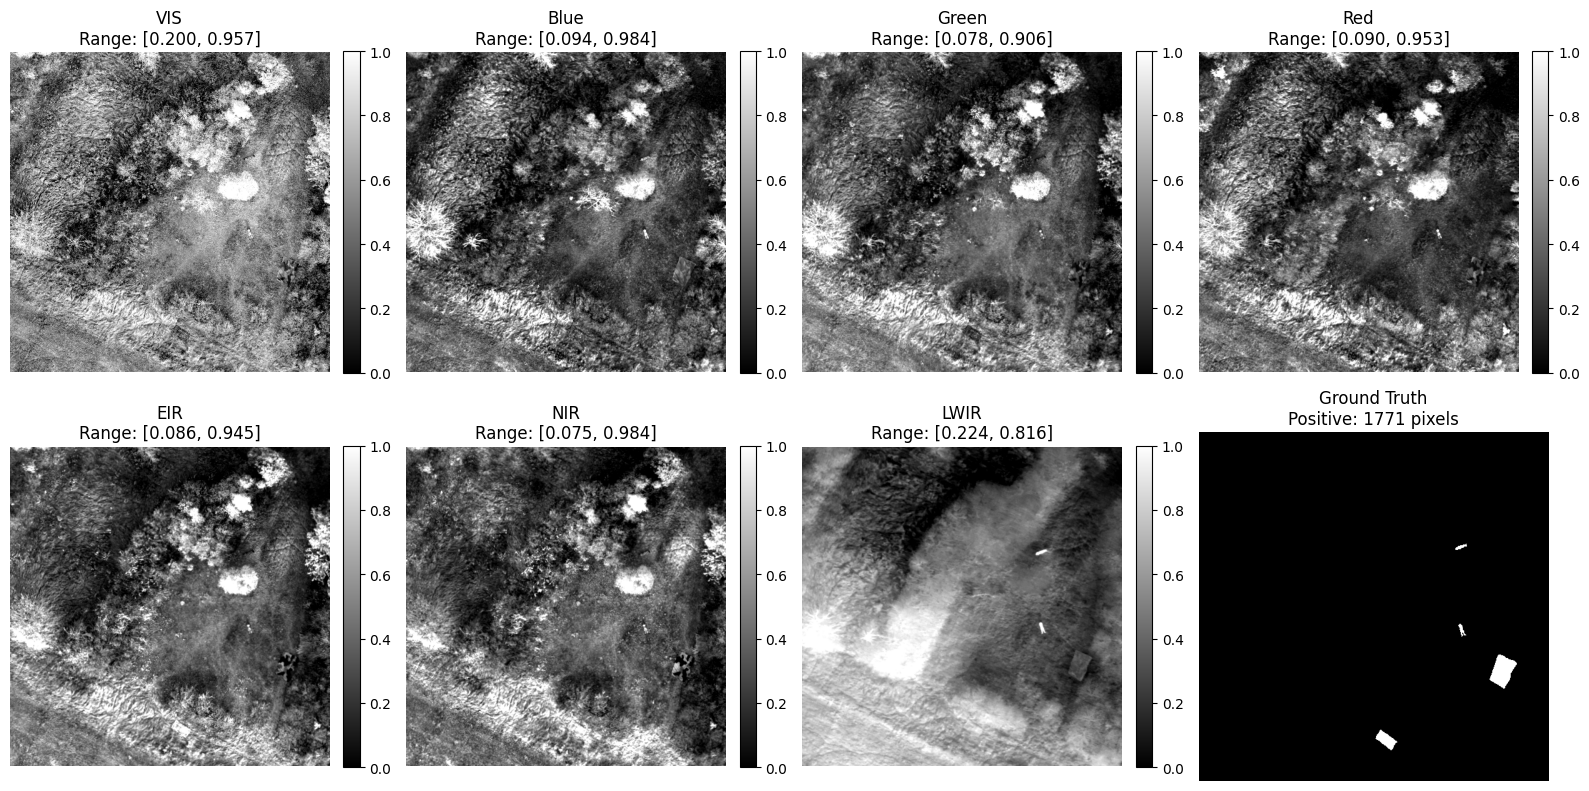

Sample 0 Statistics:
Multispectral shape: (512, 512, 7)
Ground truth shape: (512, 512, 1)
Non-zero bands: 7/7
 VIS: min=0.2000, max=0.9569, mean=0.5760
Blue: min=0.0941, max=0.9843, mean=0.2969
Green: min=0.0784, max=0.9059, mean=0.3186
 Red: min=0.0902, max=0.9529, mean=0.2698
 EIR: min=0.0863, max=0.9451, mean=0.3387
 NIR: min=0.0745, max=0.9843, mean=0.3665
LWIR: min=0.2235, max=0.8157, mean=0.4418


In [ ]:
def visualize_multispectral_sample(X, y, sample_idx=0):
    """Visualize a single multispectral sample with all bands"""

    if len(X) == 0:
        print("No data to visualize!")
        return

    sample_x = X[sample_idx]
    sample_y = y[sample_idx]

    band_names = ['VIS', 'Blue', 'Green', 'Red', 'EIR', 'NIR', 'LWIR']

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Plot each spectral band
    for i, band_name in enumerate(band_names):
        row, col = i // 4, i % 4

        band_data = sample_x[:, :, i]

        # Enhance contrast for visualization
        p2, p98 = np.percentile(band_data, (2, 98))
        if p98 > p2:
            band_enhanced = np.clip((band_data - p2) / (p98 - p2), 0, 1)
        else:
            band_enhanced = band_data

        im = axes[row, col].imshow(band_enhanced, cmap='gray')
        axes[row, col].set_title(f'{band_name}\nRange: [{band_data.min():.3f}, {band_data.max():.3f}]')
        axes[row, col].axis('off')
        plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)

    # Ground truth
    axes[1, 3].imshow(sample_y[:, :, 0], cmap='gray')
    axes[1, 3].set_title(f'Ground Truth\nPositive: {np.sum(sample_y > 0)} pixels')
    axes[1, 3].axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Sample {sample_idx} Statistics:")
    print(f"Multispectral shape: {sample_x.shape}")
    print(f"Ground truth shape: {sample_y.shape}")
    print(f"Non-zero bands: {np.sum(np.max(sample_x, axis=(0,1)) > 0)}/7")

    for i, band_name in enumerate(band_names):
        band_stats = sample_x[:, :, i]
        print(f"{band_name:>4}: min={band_stats.min():.4f}, max={band_stats.max():.4f}, mean={band_stats.mean():.4f}")

# Visualize the first sample
if len(X) > 0:
    visualize_multispectral_sample(X, y, sample_idx=0)
else:
    print("No samples loaded. Please check your dataset path.")

In [ ]:
# Required Libraries
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D,
    Cropping2D, Concatenate, Add, GlobalAveragePooling2D, Dense, Reshape
)
from tensorflow.keras.models import Model
import numpy as np

class SpectralAttentionLayer(tf.keras.layers.Layer):
    """Custom spectral attention layer for learning band importance"""

    def __init__(self, num_bands=7, **kwargs):
        super(SpectralAttentionLayer, self).__init__(**kwargs)
        self.num_bands = num_bands

    def build(self, input_shape):
        # Create layers as instance variables (FIXED)
        self.global_pool = GlobalAveragePooling2D()
        # Ensure at least 1 neuron in hidden layer
        hidden_units = max(1, self.num_bands // 2)
        self.fc1 = Dense(hidden_units, activation='relu', name='attention_fc1')
        self.fc2 = Dense(self.num_bands, activation='sigmoid', name='attention_fc2')
        super().build(input_shape)

    def call(self, inputs):
        # Calculate channel attention
        global_context = self.global_pool(inputs)
        attention_weights = self.fc1(global_context)
        attention_weights = self.fc2(attention_weights)

        # Reshape for broadcasting (FIXED: ensure proper dimensions)
        attention_weights = tf.expand_dims(tf.expand_dims(attention_weights, 1), 1)

        # Apply attention
        return inputs * attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({'num_bands': self.num_bands})
        return config

def multi_scale_spectral_fusion_cnn(input_shape=(256, 256, 7), num_classes=1):
    """
    Multi-Scale Spectral Fusion CNN for camouflaged object detection

    Key features:
    - Spectral attention for band importance learning
    - Multi-scale feature extraction with different dilation rates
    - Skip connections for fine detail preservation
    - Designed specifically for 7-band multispectral input
    """

    inputs = Input(shape=input_shape, name='multispectral_input')

    # Stage 1: Spectral Feature Extraction with Attention
    spectral_attention = SpectralAttentionLayer(num_bands=7, name='spectral_attention')(inputs)

    # Initial spectral processing
    initial_conv = Conv2D(64, (1, 1), activation='relu', name='initial_spectral_conv')(spectral_attention)
    initial_conv = BatchNormalization(name='initial_bn')(initial_conv)

    # Multi-scale block definition (IMPROVED)
    def multi_scale_block(x, filters, block_name, dilation_rates=[1, 2, 4, 8]):
        """Multi-scale convolution block with different receptive fields"""
        scales = []

        for i, dilation in enumerate(dilation_rates):
            scale = Conv2D(
                filters // len(dilation_rates),
                (3, 3),
                dilation_rate=dilation,
                padding='same',
                activation='relu',
                name=f'{block_name}_scale_{i+1}'
            )(x)
            scales.append(scale)

        # Concatenate multi-scale features
        multi_scale = Concatenate(name=f'{block_name}_concat')(scales)

        # Feature fusion with 1x1 convolution
        fused = Conv2D(filters, (1, 1), activation='relu', name=f'{block_name}_fusion')(multi_scale)
        fused = BatchNormalization(name=f'{block_name}_bn')(fused)

        # Add residual connection if input and output have same channels (FIXED)
        if tf.keras.backend.int_shape(x)[-1] == filters:
            fused = Add(name=f'{block_name}_residual')([x, fused])

        return fused

    # Encoder path with multi-scale blocks
    # Level 1 (256x256 -> 128x128)
    enc1 = multi_scale_block(initial_conv, 64, 'encoder_1')
    enc1 = Dropout(0.1, name='dropout_enc1')(enc1)
    pool1 = MaxPooling2D((2, 2), name='pool_1')(enc1)

    # Level 2 (128x128 -> 64x64)
    enc2 = multi_scale_block(pool1, 128, 'encoder_2')
    enc2 = Dropout(0.1, name='dropout_enc2')(enc2)
    pool2 = MaxPooling2D((2, 2), name='pool_2')(enc2)

    # Level 3 (64x64 -> 32x32)
    enc3 = multi_scale_block(pool2, 256, 'encoder_3')
    enc3 = Dropout(0.2, name='dropout_enc3')(enc3)
    pool3 = MaxPooling2D((2, 2), name='pool_3')(enc3)

    # Level 4 (32x32 -> 16x16)
    enc4 = multi_scale_block(pool3, 512, 'encoder_4')
    enc4 = Dropout(0.2, name='dropout_enc4')(enc4)
    pool4 = MaxPooling2D((2, 2), name='pool_4')(enc4)

    # Bottleneck (16x16)
    bottleneck = multi_scale_block(pool4, 1024, 'bottleneck', dilation_rates=[1, 2, 4, 8, 16])
    bottleneck = Dropout(0.3, name='dropout_bottleneck')(bottleneck)

    # Decoder path with skip connections (IMPROVED)
    def decoder_block(x, skip_connection, filters, block_name):
        """Decoder block with skip connections and multi-scale processing"""
        # Upsample
        up = UpSampling2D((2, 2), name=f'{block_name}_upsample')(x)

        # Get shapes for dimension matching (FIXED)
        up_shape = tf.keras.backend.int_shape(up)
        skip_shape = tf.keras.backend.int_shape(skip_connection)

        # Ensure spatial dimensions match for concatenation
        if up_shape[1] != skip_shape[1] or up_shape[2] != skip_shape[2]:
            # Calculate cropping needed
            crop_h = max(0, up_shape[1] - skip_shape[1])
            crop_w = max(0, up_shape[2] - skip_shape[2])

            if crop_h > 0 or crop_w > 0:
                up = Cropping2D(cropping=((crop_h//2, crop_h - crop_h//2),
                                        (crop_w//2, crop_w - crop_w//2)),
                              name=f'{block_name}_crop')(up)

        # Process skip connection
        skip_processed = Conv2D(filters, (1, 1), activation='relu',
                               name=f'{block_name}_skip_process')(skip_connection)

        # Concatenate upsampled features with processed skip connection
        merged = Concatenate(name=f'{block_name}_merge')([up, skip_processed])

        # Multi-scale processing of merged features
        decoded = multi_scale_block(merged, filters, f'{block_name}_decode')
        decoded = Dropout(0.1, name=f'dropout_{block_name}')(decoded)

        return decoded

    # Decoder path
    dec4 = decoder_block(bottleneck, enc4, 512, 'decoder_4')  # 16x16 -> 32x32
    dec3 = decoder_block(dec4, enc3, 256, 'decoder_3')       # 32x32 -> 64x64
    dec2 = decoder_block(dec3, enc2, 128, 'decoder_2')       # 64x64 -> 128x128
    dec1 = decoder_block(dec2, enc1, 64, 'decoder_1')        # 128x128 -> 256x256

    # Final refinement layers
    final_conv1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='final_conv1')(dec1)
    final_conv1 = BatchNormalization(name='final_bn1')(final_conv1)

    final_conv2 = Conv2D(16, (3, 3), padding='same', activation='relu', name='final_conv2')(final_conv1)
    final_conv2 = BatchNormalization(name='final_bn2')(final_conv2)

    # Output layer
    if num_classes == 1:
        # Binary segmentation
        output = Conv2D(1, (1, 1), activation='sigmoid', name='output')(final_conv2)
    else:
        # Multi-class segmentation
        output = Conv2D(num_classes, (1, 1), activation='softmax', name='output')(final_conv2)

    model = Model(inputs=inputs, outputs=output, name='MultiScaleSpectralFusionCNN')
    return model

# Test model building
def test_model_building():
    """Test if model builds successfully"""
    try:
        print("🔨 Testing model building...")

        # Test with different input shapes for memory efficiency
        test_shapes = [
            (128, 128, 7),  # Memory efficient
            (256, 256, 7),  # Standard
        ]

        for shape in test_shapes:
            print(f"Testing shape: {shape}")
            model = multi_scale_spectral_fusion_cnn(input_shape=shape, num_classes=1)
            print(f"✅ Model built successfully with shape {shape}")
            print(f"   Total parameters: {model.count_params():,}")

            # Test model compilation
            model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            print(f"✅ Model compiled successfully")

            # Test with dummy data
            dummy_input = np.random.rand(1, *shape).astype(np.float32)
            dummy_output = model.predict(dummy_input, verbose=0)
            print(f"✅ Model prediction test passed: {dummy_output.shape}")
            print()

        return True

    except Exception as e:
        print(f"❌ Model building failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# Build the model with error handling
def build_model_safely(input_shape=(128, 128, 7)):
    """Safely build model with error handling"""

    try:
        print("🏗️ Building Multi-Scale Spectral Fusion CNN...")

        model = multi_scale_spectral_fusion_cnn(input_shape=input_shape, num_classes=1)

        print("✅ Model built successfully!")
        print(f"📊 Model Summary:")
        print(f"   Input shape: {input_shape}")
        print(f"   Total parameters: {model.count_params():,}")
        print(f"   Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

        # Display model summary
        model.summary()

        return model

    except Exception as e:
        print(f"❌ Model building failed: {e}")
        print("💡 Try reducing input size or check TensorFlow installation")
        return None

# Usage example
if __name__ == "__main__":
    # Test model building
    success = test_model_building()

    if success:
        # Build model for actual use
        model = build_model_safely(input_shape=(128, 128, 7))

        if model is not None:
            print("\n🎉 Model ready for training!")
            print("Next steps:")
            print("1. Load your MUDCAD-X data")
            print("2. Compile model with appropriate loss function")
            print("3. Train the model")

🔨 Testing model building...
Testing shape: (128, 128, 7)
✅ Model built successfully with shape (128, 128, 7)
   Total parameters: 17,817,329
✅ Model compiled successfully
✅ Model prediction test passed: (1, 128, 128, 1)

Testing shape: (256, 256, 7)
✅ Model built successfully with shape (256, 256, 7)
   Total parameters: 17,817,329
✅ Model compiled successfully
✅ Model prediction test passed: (1, 256, 256, 1)

🏗️ Building Multi-Scale Spectral Fusion CNN...
✅ Model built successfully!
📊 Model Summary:
   Input shape: (128, 128, 7)
   Total parameters: 17,817,329
   Trainable parameters: 17,811,217


Model: "MultiScaleSpectralFusionCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ multispectral_input │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_attention  │ (None, 128, 128,  │         52 │ multispectral_in… │
│ (SpectralAttention… │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_spectral_c… │ (None, 128, 128,  │        512 │ spectral_attenti… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_bn          │ (None, 128, 128,  │        256 │ initial_spectral… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_scale_1   │ (None, 128, 128,  │      9,232 │ initial_bn[0][0]  │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_scale_2   │ (None, 128, 128,  │      9,232 │ initial_bn[0][0]  │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_scale_3   │ (None, 128, 128,  │      9,232 │ initial_bn[0][0]  │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_scale_4   │ (None, 128, 128,  │      9,232 │ initial_bn[0][0]  │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_concat    │ (None, 128, 128,  │          0 │ encoder_1_scale_… │
│ (Concatenate)       │ 64)               │            │ encoder_1_scale_… │
│                     │                   │            │ encoder_1_scale_… │
│                     │                   │            │ encoder_1_scale_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_fusion    │ (None, 128, 128,  │      4,160 │ encoder_1_concat… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_bn        │ (None, 128, 128,  │        256 │ encoder_1_fusion… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1_residual  │ (None, 128, 128,  │          0 │ initial_bn[0][0], │
│ (Add)               │ 64)               │            │ encoder_1_bn[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_enc1        │ (None, 128, 128,  │          0 │ encoder_1_residu… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_1              │ (None, 64, 64,    │          0 │ dropout_enc1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2_scale_1   │ (None, 64, 64,    │     18,464 │ pool_1[0][0]      │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_2_scale_2   │ (None, 64, 64,    │     18,464 │ pool_1[0][0]      │
│ (Conv2D)            │ 32)               │            │                 

 Total params: 17,817,329 (67.97 MB)

 Trainable params: 17,811,217 (67.94 MB)

 Non-trainable params: 6,112 (23.88 KB)


🎉 Model ready for training!
Next steps:
1. Load your MUDCAD-X data
2. Compile model with appropriate loss function
3. Train the model


In [ ]:
import numpy as np

def fix_mask_for_multispectral(image, mask):
    """
    Fix mask shape compatibility for multispectral boolean indexing

    Args:
        image: Multispectral image (H, W, Bands)
        mask: Ground truth mask (H, W) or (H, W, 1)

    Returns:
        Compatible mask for boolean indexing
    """

    # Convert mask to boolean if needed
    if mask.dtype != bool:
        mask_bool = mask > 0.5
    else:
        mask_bool = mask

    # Handle different mask dimensions
    if len(mask_bool.shape) == 2:  # (H, W)
        # Expand to (H, W, 1)
        mask_bool = np.expand_dims(mask_bool, axis=-1)

    if len(mask_bool.shape) == 3 and mask_bool.shape[-1] == 1:  # (H, W, 1)
        # For boolean indexing, we only need the spatial mask
        mask_bool = mask_bool[:, :, 0]  # Back to (H, W)

    return mask_bool

def extract_pixels_safely(image, mask):
    """
    Safely extract pixels using boolean mask

    Args:
        image: Multispectral image (H, W, Bands)
        mask: Ground truth mask (H, W) or (H, W, 1)

    Returns:
        Extracted pixels (N_pixels, Bands)
    """

    # Fix mask shape
    mask_2d = fix_mask_for_multispectral(image, mask)

    # Extract pixels - this gives us (N_pixels, Bands)
    extracted_pixels = image[mask_2d]

    return extracted_pixels

# Test the fix
def test_mask_fix():
    """Test the mask fixing function"""

    # Create dummy data
    dummy_image = np.random.rand(64, 64, 7)
    dummy_mask_2d = np.random.randint(0, 2, (64, 64))
    dummy_mask_3d = np.random.randint(0, 2, (64, 64, 1))

    print("🧪 Testing mask fixes...")

    # Test 2D mask
    try:
        pixels_2d = extract_pixels_safely(dummy_image, dummy_mask_2d)
        print(f"✅ 2D mask works: {pixels_2d.shape}")
    except Exception as e:
        print(f"❌ 2D mask failed: {e}")

    # Test 3D mask
    try:
        pixels_3d = extract_pixels_safely(dummy_image, dummy_mask_3d)
        print(f"✅ 3D mask works: {pixels_3d.shape}")
    except Exception as e:
        print(f"❌ 3D mask failed: {e}")

test_mask_fix()

🧪 Testing mask fixes...
✅ 2D mask works: (2062, 7)
✅ 3D mask works: (2059, 7)


In [ ]:
def analyze_spectral_signatures_fixed(image, mask=None, num_samples=1000, save_path=None):
    """
    FIXED: Analyze and visualize spectral signatures from the image
    """

    band_names = ['VIS', 'Blue', 'Green', 'Red', 'EIR', 'NIR', 'LWIR']
    wavelengths = [550, 450, 550, 650, 750, 850, 1050]  # Approximate wavelengths in nm

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # FIXED: Prepare data with proper masking
    if mask is not None:
        # Use the safe extraction function
        valid_pixels = extract_pixels_safely(image, mask)
        print(f"Extracted {len(valid_pixels)} valid pixels from mask")
    else:
        # Reshape all pixels
        valid_pixels = image.reshape(-1, image.shape[-1])
        print(f"Using all {len(valid_pixels)} pixels")

    # Handle empty mask case
    if len(valid_pixels) == 0:
        print("⚠️ Warning: No valid pixels found in mask")
        valid_pixels = image.reshape(-1, image.shape[-1])[:100]  # Use first 100 pixels

    # Random sampling for performance
    if len(valid_pixels) > num_samples:
        indices = np.random.choice(len(valid_pixels), num_samples, replace=False)
        sampled_pixels = valid_pixels[indices]
    else:
        sampled_pixels = valid_pixels

    # 1. Individual spectral signatures
    axes[0, 0].plot(wavelengths, sampled_pixels[:min(50, len(sampled_pixels))].T,
                   alpha=0.3, color='blue')
    mean_signature = np.mean(sampled_pixels, axis=0)
    std_signature = np.std(sampled_pixels, axis=0)

    axes[0, 0].plot(wavelengths, mean_signature, 'r-', linewidth=3, label='Mean')
    axes[0, 0].fill_between(wavelengths, mean_signature - std_signature,
                           mean_signature + std_signature, alpha=0.3, color='red', label='±1σ')

    axes[0, 0].set_title('Spectral Signatures', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Wavelength (nm)')
    axes[0, 0].set_ylabel('Reflectance')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xticks(wavelengths)
    axes[0, 0].set_xticklabels(band_names, rotation=45)

    # 2. Band correlation matrix
    if len(sampled_pixels) > 1:
        correlation_matrix = np.corrcoef(sampled_pixels.T)

        im_corr = axes[0, 1].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        axes[0, 1].set_title('Band Correlation Matrix', fontsize=14, fontweight='bold')
        axes[0, 1].set_xticks(range(len(band_names)))
        axes[0, 1].set_xticklabels(band_names, rotation=45)
        axes[0, 1].set_yticks(range(len(band_names)))
        axes[0, 1].set_yticklabels(band_names)

        # Add correlation values as text
        for i in range(len(band_names)):
            for j in range(len(band_names)):
                text = axes[0, 1].text(j, i, f'{correlation_matrix[i, j]:.2f}',
                                      ha="center", va="center", color="black", fontsize=9)

        plt.colorbar(im_corr, ax=axes[0, 1])
    else:
        axes[0, 1].text(0.5, 0.5, 'Not enough pixels\nfor correlation',
                       ha='center', va='center', transform=axes[0, 1].transAxes, fontsize=14)

    # 3. Band histograms
    colors = ['purple', 'blue', 'green', 'red', 'orange', 'brown', 'pink']

    for i, (band_name, color) in enumerate(zip(band_names, colors)):
        if i < sampled_pixels.shape[1]:
            band_data = sampled_pixels[:, i]
            axes[1, 0].hist(band_data, bins=30, alpha=0.6, label=band_name,
                           color=color, density=True)

    axes[1, 0].set_title('Band Value Distributions', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Pixel Value')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. 2D scatter plot
    if sampled_pixels.shape[1] >= 2:
        band_vars = np.var(sampled_pixels, axis=0)
        top_bands = np.argsort(band_vars)[-2:]

        scatter = axes[1, 1].scatter(sampled_pixels[:, top_bands[0]],
                                    sampled_pixels[:, top_bands[1]],
                                    c=np.mean(sampled_pixels, axis=1),
                                    cmap='viridis', alpha=0.6, s=10)

        axes[1, 1].set_title(f'Band Scatter Plot\n({band_names[top_bands[0]]} vs {band_names[top_bands[1]]})',
                            fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel(f'{band_names[top_bands[0]]} Band')
        axes[1, 1].set_ylabel(f'{band_names[top_bands[1]]} Band')
        axes[1, 1].grid(True, alpha=0.3)

        plt.colorbar(scatter, ax=axes[1, 1], label='Mean Reflectance')

    plt.suptitle('Spectral Signature Analysis (Fixed)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    # Print statistics
    print("\n📊 SPECTRAL STATISTICS:")
    print("="*40)
    print(f"Total pixels analyzed: {len(sampled_pixels)}")
    for i, band_name in enumerate(band_names[:sampled_pixels.shape[1]]):
        band_data = sampled_pixels[:, i]
        print(f"{band_name:>6}: μ={band_data.mean():.3f}, σ={band_data.std():.3f}, "
              f"range=[{band_data.min():.3f}, {band_data.max():.3f}]")

# Usage
# analyze_spectral_signatures_fixed(your_image, mask=your_mask)

In [4]:
%cd MultispeCOD/

/content/MultispeCOD


In [5]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [6]:
!git add .

In [8]:
!git add MultispeCOD.ipynb

fatal: pathspec 'MultispeCOD.ipynb' did not match any files
